> **문제 개요**
1. 자동차 보험회사에서는 정확한 보험료를 측정하는 것이 매우 중요하다.
    * 안전한 운전을 하는 저위험 고객에게는 낮은 보험료를 제시하고,
    * 위험한 운전을 하는 고위험 고객에게는 높은 보험료를 제시한다.
4. 고객 데이터를 통해, 향후 보험금 청구를 할 고객을 미리 예측해보도록 한다.

> **접근 방법**
1. Binary Classification: 보험금 청구(1), 보험금 미청구(0)
2. 사용할 Algorithm: DNN (Fully Connected Network만을 사용해본다.)
3. Metrics for Model Performance: AUC-ROC Score

> **목표**
* AUC-ROC Score를 최대화할 수 있는 DNN 모델을 만든다.

# 1. Import Libraries Required

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd

# Ignore FutureWarning Messages
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Save Variables
import joblib

# Train vs. Test
from sklearn.model_selection import train_test_split

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import ReLU, ThresholdedReLU, LeakyReLU, PReLU, ELU
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adagrad, Adadelta

# Model Plotting
from tensorflow.keras.utils import plot_model

# Evaluations
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score

# Mount My Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 2. Load Data

In [2]:
df_folderpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/Midterm Exam/Jupyter Notebook/data'
df_fname = 'train.csv'
df_fpath = df_folderpath + '/' + df_fname

df = pd.read_csv(df_fpath)
print(df.shape)

(416712, 59)


In [3]:
df.head()

,id,target,car_01_cat,car_02_cat,car_03_cat,car_04_cat,car_05,car_06,car_07_cat,car_08_cat,car_09,car_10,car_11,car_12_cat,car_13_cat,car_14_cat,car_15_cat,car_16_cat,cus_01_bin,cus_02,cus_03_bin,cus_04_bin,cus_05,cus_06_bin,cus_07_bin,cus_08_bin,cus_09,cus_10_cat,cus_11_bin,cus_12_bin,cus_13,cus_14_cat,cus_15_bin,cus_16_cat,cus_17_bin,cus_18_bin,idx_01_bin,idx_02,idx_03,idx_04,idx_05_bin,idx_06_bin,idx_07,idx_08,idx_09,idx_10,idx_11,idx_12,idx_13_bin,idx_14,idx_15_bin,idx_16_bin,idx_17,idx_18,idx_19,idx_20,loc_01,loc_02,loc_03
0,C000000,0,4,-1,0,12,3.316625,0.370810,1,1,0.754792,3,0.400000,2,11,-1,1,1,0,2,0,0,0,0,0,0,5,1,1,0,1,0,0,1,0,1,0,2,0.0,0.2,0,0,2,17,3,0.5,7,10,0,7,0,0,0,3,7,1,0.6,0.7,0.878564
1,C000001,0,0,1,0,39,2.449490,0.374433,1,1,0.614780,1,0.316070,0,0,-1,1,1,0,4,0,0,0,0,1,0,13,1,0,0,6,0,1,1,0,0,1,4,0.0,0.8,0,0,2,12,1,0.8,9,9,0,11,0,1,0,6,8,1,0.6,0.6,0.981708
2,C000002,0,0,-1,2,100,3.464102,0.423084,1,1,0.815665,0,0.399750,1,7,-1,1,0,0,6,0,0,0,0,0,1,9,0,1,0,3,0,0,1,0,0,0,0,0.2,0.4,0,0,2,5,3,0.9,4,6,0,11,0,0,0,1,8,3,0.2,0.9,0.495606
3,C000003,0,9,1,0,93,3.741657,0.316228,0,0,1.068114,3,0.400000,2,11,1,1,1,1,10,0,0,0,0,0,0,10,1,0,0,3,0,1,4,0,0,0,2,0.1,0.4,1,0,2,8,2,0.3,4,8,1,7,0,0,3,3,8,4,1.8,0.9,2.066549
4,C000004,0,0,0,1,104,3.741657,0.430116,1,0,1.509768,2,0.447214,0,10,-1,1,1,0,1,0,0,0,1,0,0,3,0,0,0,2,0,0,2,0,1,1,0,0.4,0.8,1,0,3,3,3,0.5,7,8,0,6,0,0,1,1,7,4,0.0,0.4,0.740355


In [4]:
# Features
    # id: Customer ID (PK)
    # target: 보험금 청구 여부 (1: Positive, 0: Negative)
    # car: 차량 관련 특성
    # cus: 고객 관련 특성
    # idx: 보험사 자체 보유 중인 특성
    # loc: 주소 관련 특성
print('Number of Features:', len(df.columns) - 2)

Number of Features: 57


In [5]:
# Delete 'id' column (분석상 불필요함)
df = df.drop('id', axis=1)
df.head()

,target,car_01_cat,car_02_cat,car_03_cat,car_04_cat,car_05,car_06,car_07_cat,car_08_cat,car_09,car_10,car_11,car_12_cat,car_13_cat,car_14_cat,car_15_cat,car_16_cat,cus_01_bin,cus_02,cus_03_bin,cus_04_bin,cus_05,cus_06_bin,cus_07_bin,cus_08_bin,cus_09,cus_10_cat,cus_11_bin,cus_12_bin,cus_13,cus_14_cat,cus_15_bin,cus_16_cat,cus_17_bin,cus_18_bin,idx_01_bin,idx_02,idx_03,idx_04,idx_05_bin,idx_06_bin,idx_07,idx_08,idx_09,idx_10,idx_11,idx_12,idx_13_bin,idx_14,idx_15_bin,idx_16_bin,idx_17,idx_18,idx_19,idx_20,loc_01,loc_02,loc_03
0,0,4,-1,0,12,3.316625,0.370810,1,1,0.754792,3,0.400000,2,11,-1,1,1,0,2,0,0,0,0,0,0,5,1,1,0,1,0,0,1,0,1,0,2,0.0,0.2,0,0,2,17,3,0.5,7,10,0,7,0,0,0,3,7,1,0.6,0.7,0.878564
1,0,0,1,0,39,2.449490,0.374433,1,1,0.614780,1,0.316070,0,0,-1,1,1,0,4,0,0,0,0,1,0,13,1,0,0,6,0,1,1,0,0,1,4,0.0,0.8,0,0,2,12,1,0.8,9,9,0,11,0,1,0,6,8,1,0.6,0.6,0.981708
2,0,0,-1,2,100,3.464102,0.423084,1,1,0.815665,0,0.399750,1,7,-1,1,0,0,6,0,0,0,0,0,1,9,0,1,0,3,0,0,1,0,0,0,0,0.2,0.4,0,0,2,5,3,0.9,4,6,0,11,0,0,0,1,8,3,0.2,0.9,0.495606
3,0,9,1,0,93,3.741657,0.316228,0,0,1.068114,3,0.400000,2,11,1,1,1,1,10,0,0,0,0,0,0,10,1,0,0,3,0,1,4,0,0,0,2,0.1,0.4,1,0,2,8,2,0.3,4,8,1,7,0,0,3,3,8,4,1.8,0.9,2.066549
4,0,0,0,1,104,3.741657,0.430116,1,0,1.509768,2,0.447214,0,10,-1,1,1,0,1,0,0,0,1,0,0,3,0,0,0,2,0,0,2,0,1,1,0,0.4,0.8,1,0,3,3,3,0.5,7,8,0,6,0,0,1,1,7,4,0.0,0.4,0.740355


In [6]:
df.info()

# 본 dataset에서 Null Values는 모두 -1로 일괄 표기함으로써, 전처리가 완료되었음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416712 entries, 0 to 416711
Data columns (total 58 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   target      416712 non-null  int64  
 1   car_01_cat  416712 non-null  int64  
 2   car_02_cat  416712 non-null  int64  
 3   car_03_cat  416712 non-null  int64  
 4   car_04_cat  416712 non-null  int64  
 5   car_05      416712 non-null  float64
 6   car_06      416712 non-null  float64
 7   car_07_cat  416712 non-null  int64  
 8   car_08_cat  416712 non-null  int64  
 9   car_09      416712 non-null  float64
 10  car_10      416712 non-null  int64  
 11  car_11      416712 non-null  float64
 12  car_12_cat  416712 non-null  int64  
 13  car_13_cat  416712 non-null  int64  
 14  car_14_cat  416712 non-null  int64  
 15  car_15_cat  416712 non-null  int64  
 16  car_16_cat  416712 non-null  int64  
 17  cus_01_bin  416712 non-null  int64  
 18  cus_02      416712 non-null  int64  
 19  cu

In [7]:
# 모든 Columns의 datatype을 float32로 변환하도록 한다.
df = df.astype('float32')

In [8]:
# 각 Column별 % of Null Values를 확인해보자.
NullPct_df = np.round(np.mean(df == -1, axis=0) * 100, 2)
NullPct_df = pd.DataFrame(NullPct_df)
NullPct_df.columns = ['% of Null Values']
NullPct_df = NullPct_df[NullPct_df > 0].dropna(axis=0)
NullPct_df

,% of Null Values
car_02_cat,44.83
car_06,7.14
car_12_cat,0.10
car_13_cat,0.02
car_14_cat,69.15
car_16_cat,1.93
cus_10_cat,0.01
cus_14_cat,0.98
cus_16_cat,0.04
loc_03,18.12


In [9]:
# Null Values를 1개 이상 포함하는 Columns 중 Outstanding한 것들은 다음과 같다.
    # car_02_cat: 약 45%가 Null Values
    # car_14_cat: 약 70%가 Null Values
    # loc_03: 약 20%가 Null Values

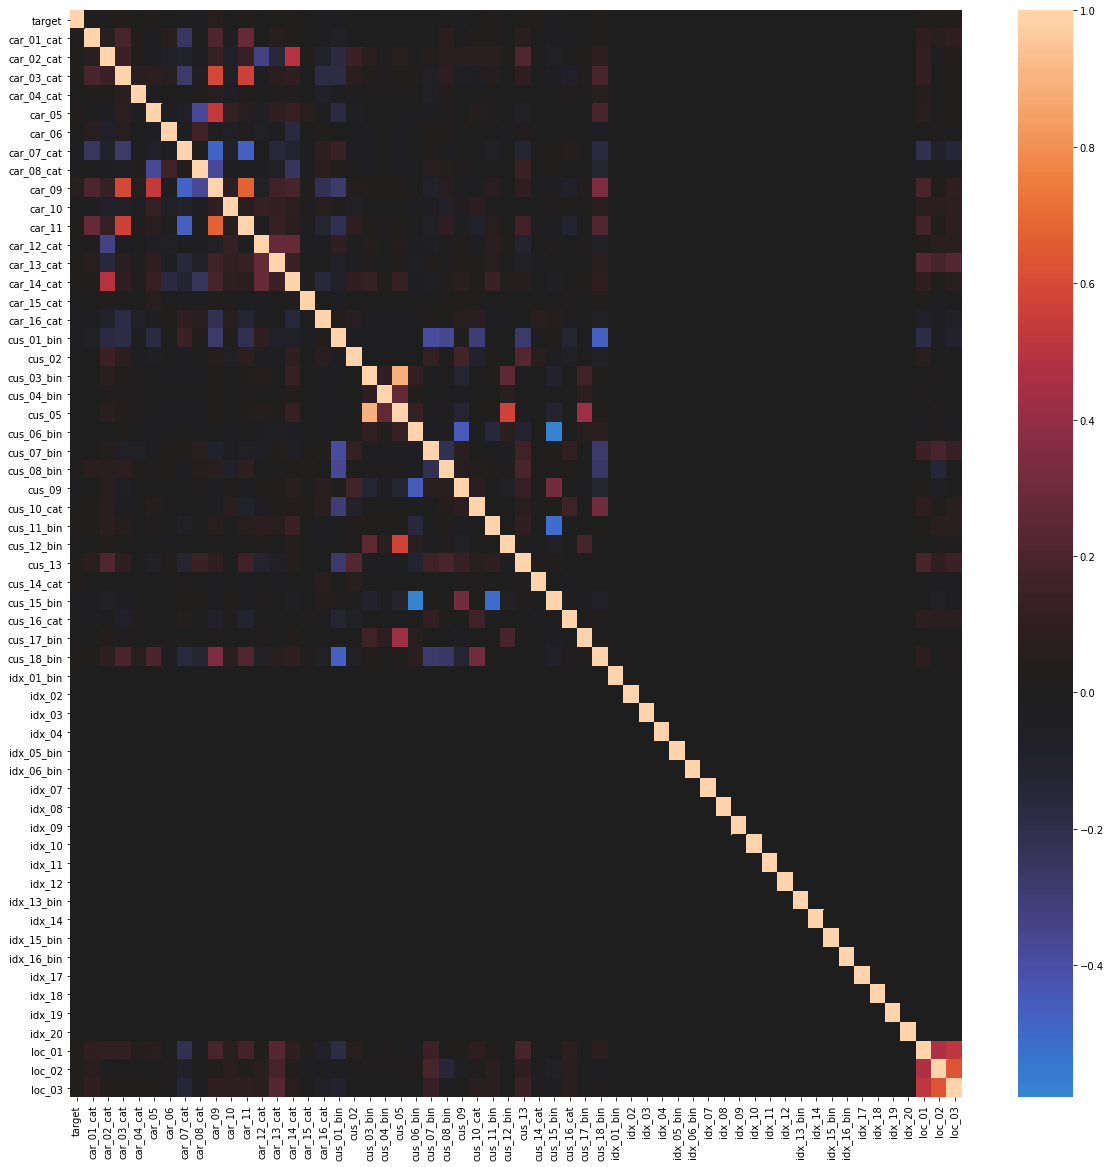

''

In [10]:
# Column별로 Correlation을 시각화하여 확인해보자.

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(ax=ax, data=df.corr(), center=0)
plt.show()
;

In [11]:
# target과 직접적으로 Correlation을 지닌 특성은 존재하지 않음
# car 특성들 사이의 강한 Correlation이 부분적으로 발견됨
# cus 특성들 사이의 강한 Correlation이 부분적으로 발견됨
# loc 특성들 사이의 강한 Positive Correlation이 발견됨

In [12]:
# Split into INPUT & TARGET Columns

df_input = df.drop('target', axis=1)
df_target = df[['target']]

print('Input Shape:', df_input.shape)
print('Target Shape:', df_target.shape)

Input Shape: (416712, 57)
Target Shape: (416712, 1)


# 3. Split into TRAIN & VALIDATE Sets

In [13]:
# Target Value의 Positive/Negative 비율이 balanced되도록 나눈다. (stratify)

train_input, val_input, train_target, val_target = \
    train_test_split(
        df_input,
        df_target,
        test_size=0.2,
        stratify=df_target
    )

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)

(333369, 57) (333369, 1)
(83343, 57) (83343, 1)


In [14]:
# Save TRAIN & VALIDATE Sets

save_folderpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/Midterm Exam/Jupyter Notebook/data'
save_fname = 'train_validate_sets.pkl'
save_fpath = save_folderpath + '/' + save_fname

with open(save_fpath, 'wb') as f:
    joblib.dump({
        'train_input': train_input,
        'train_target': train_target,
        'val_input': val_input,
        'val_target': val_target
    }, f)

# 4. Data Scaling

In [18]:
# MinMax Scaler, Standard Scaler, Robust Scaler 중 어떤 방법을 사용할 것인가?

# 우선, 데이터의 Outlier 비율을 확인해보자.
q1 = df_input.quantile(q=0.25, axis=0)
q3 = df_input.quantile(q=0.75, axis=0)
iqr = q3 - q1
lowerwhisker = q1 - 1.5 * iqr
upperwhisker = q3 + 1.5 * iqr

OutlierPct_df = np.round(np.mean((df_input < lowerwhisker) | (df_input > upperwhisker), axis=0) * 100, 2)
OutlierPct_df = pd.DataFrame(OutlierPct_df)
OutlierPct_df.columns = ['% of Outliers']
OutlierPct_df = OutlierPct_df[OutlierPct_df > 0].dropna(axis=0)
OutlierPct_df = OutlierPct_df.sort_values('% of Outliers', ascending=False)
OutlierPct_df

,% of Outliers
loc_03,20.31
cus_07_bin,18.55
car_07_cat,17.03
car_08_cat,16.76
car_03_cat,16.51
cus_08_bin,16.41
idx_16_bin,15.33
cus_06_bin,15.29
idx_06_bin,12.26
cus_11_bin,12.10


In [20]:
# 위와 같이 Outliers 비율이 상당히 높은 특성들이 많으므로, Robust Scaler를 사용하도록 한다.

scaler = RobustScaler()
scaler.fit_transform(train_input)
val_input = scaler.transform(val_input)

# 5. User-Defined Functions for Modeling & Evaluations

In [23]:
# (1) 모델 구조 만들기

def CreateModel(weight_regularization, dropout, batch_norm, activation, *args):

    model = Sequential()

    for iLayer in range(len(args)):

        if weight_regularization == False:
            model.add(Dense(args[iLayer], input_shape=(train_input.shape[-1], )))
        else:
            model.add(Dense(args[iLayer], kernel_regularizer=weight_regularization, input_shape=(train_input.shape[-1], )))

        model.add(activation)

        if batch_norm == True:
            model.add(BatchNormalization())
        
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Dense(1, name='output', activation='sigmoid'))

    return model

# (2) 모델 Compiling

def CompileModel(model, optimizer, metrics_list=[AUC()]):

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=metrics_list
    )

# (3) 모델 Fitting

def FitModel(model, epoch_cnt, batch_size):

    history = model.fit(
        train_input,
        train_target,
        epochs=epoch_cnt,
        batch_size=batch_size,
        validation_data=(val_input, val_target),
        verbose=0
    )

    history = pd.DataFrame(history.history)
    
    return history

# (4) 모델 Fit Result Visualization

def VisualizeHistory(history):

    epoch_cnt = history.shape[0]
    epoch_list = range(1, epoch_cnt + 1, 1)

    train_loss = history.iloc[:, 0]
    train_auc = history.iloc[:, 1]
    val_loss = history.iloc[:, 2]
    val_auc = history.iloc[:, 3]

    row_cnt = 1
    col_cnt = 2

    fig, axes = plt.subplots(nrows=row_cnt, ncols=col_cnt, sharex=True, figsize=(20, 10))

    # Loss

    plt.subplot(row_cnt, col_cnt, 1)

    plt.plot(epoch_list, train_loss, 'b', label='train loss')
    plt.plot(epoch_list, val_loss, 'r', label='validate loss')

    plt.title('Loss: Train vs Validate')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.xlim(0, epoch_cnt + 1)
    plt.xticks(np.arange(0, epoch_cnt + 1, 1))
    plt.legend()

    # AUC

    plt.subplot(row_cnt, col_cnt, 2)    

    plt.plot(epoch_list, train_auc, 'b', label='train auc')
    plt.plot(epoch_list, val_auc, 'r', label='validate auc')

    plt.title('AUC: Train vs Validate')
    plt.xlabel('epoch')
    plt.ylabel('auc')

    plt.xlim(0, epoch_cnt + 1)
    plt.xticks(np.arange(0, epoch_cnt + 1, 1))
    plt.legend()

    plt.show()
    ;

# 6. Model Training

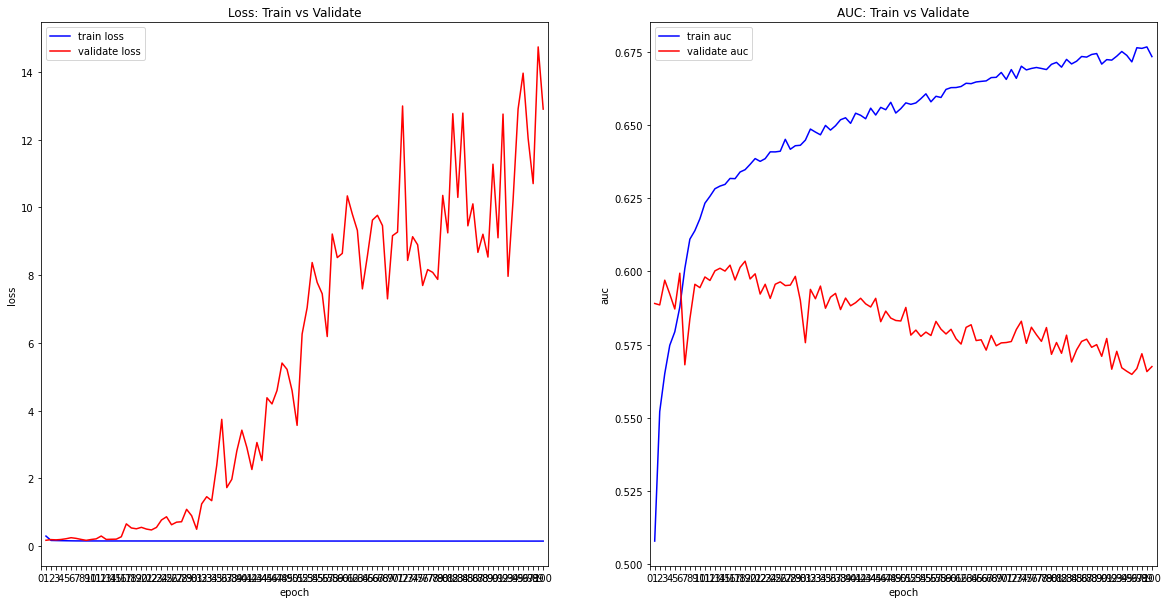

In [24]:
model = CreateModel(
    False, # Weight Regularization
    0.25, # Dropout
    True, # Batch Normalization
    ELU(), # Activation Function
    128, 4 # Hidden Layers & Nodes
)

CompileModel(
    model=model,
    optimizer=Nadam(learning_rate=0.001)
)

history = FitModel(
    model=model,
    epoch_cnt=100,
    batch_size=256
)

VisualizeHistory(history)

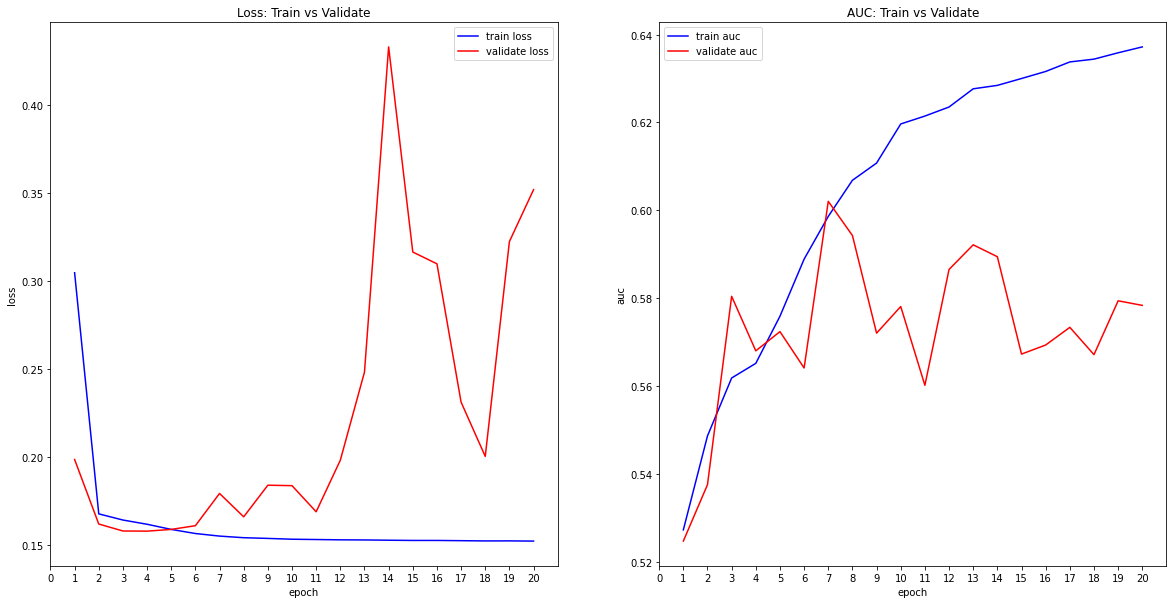

In [25]:
# 20번째 epoch부터 overfitting되므로, epoch=20으로 model을 새롭게 fitting한다.

model = CreateModel(
    False, # Weight Regularization
    0.25, # Dropout
    True, # Batch Normalization
    ELU(), # Activation Function
    128, 4 # Hidden Layers & Nodes
)

CompileModel(
    model=model,
    optimizer=Nadam(learning_rate=0.001)
)

history = FitModel(
    model=model,
    epoch_cnt=20,
    batch_size=256
)

VisualizeHistory(history)

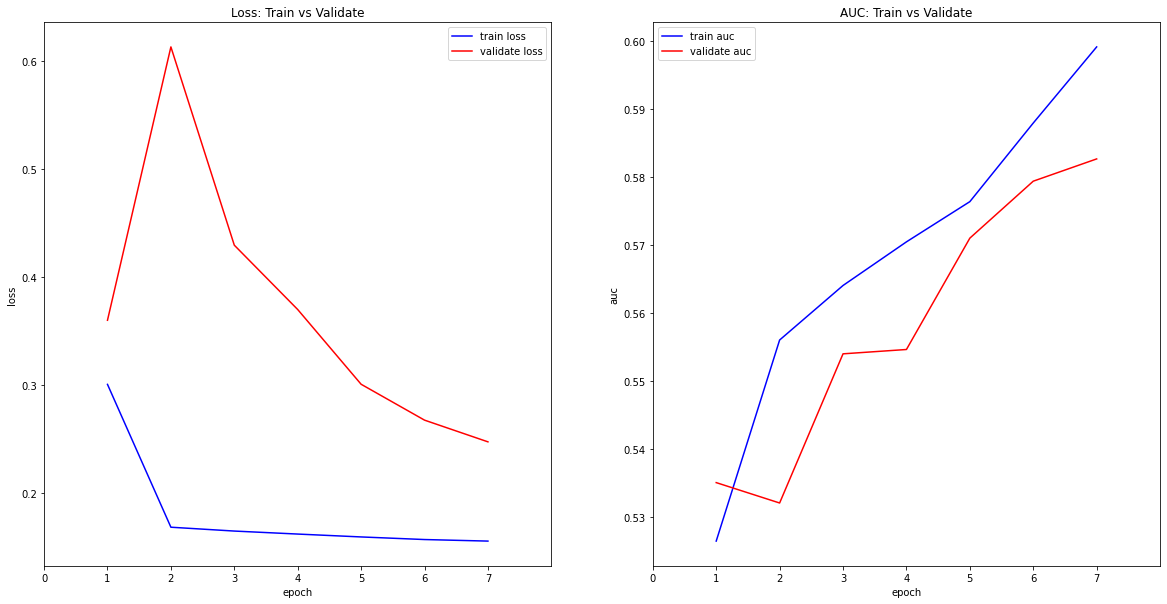

In [26]:
# epoch=7으로 model을 새롭게 fitting한다.

model = CreateModel(
    False, # Weight Regularization
    0.25, # Dropout
    True, # Batch Normalization
    ELU(), # Activation Function
    128, 4 # Hidden Layers & Nodes
)

CompileModel(
    model=model,
    optimizer=Nadam(learning_rate=0.001)
)

history = FitModel(
    model=model,
    epoch_cnt=7,
    batch_size=256
)

VisualizeHistory(history)

# 7. Apply Model to Test Dataset

In [30]:
# Load Test Dataset

df_folderpath = '/content/drive/MyDrive/03. Kookmin AI Big Data MBA/Semester 3_032021-062021/2. Deep Learning/Jupyter Notebook/Midterm Exam/Jupyter Notebook/data'
df_fname = 'test_sample.csv'
df_fpath = df_folderpath + '/' + df_fname

test_df = pd.read_csv(df_fpath)
print(test_df.shape)

(35700, 59)


In [32]:
# Delete 'id' column (분석상 불필요함)
test_df = test_df.drop('id', axis=1)
test_df.head()

,target,car_01_cat,car_02_cat,car_03_cat,car_04_cat,car_05,car_06,car_07_cat,car_08_cat,car_09,car_10,car_11,car_12_cat,car_13_cat,car_14_cat,car_15_cat,car_16_cat,cus_01_bin,cus_02,cus_03_bin,cus_04_bin,cus_05,cus_06_bin,cus_07_bin,cus_08_bin,cus_09,cus_10_cat,cus_11_bin,cus_12_bin,cus_13,cus_14_cat,cus_15_bin,cus_16_cat,cus_17_bin,cus_18_bin,idx_01_bin,idx_02,idx_03,idx_04,idx_05_bin,idx_06_bin,idx_07,idx_08,idx_09,idx_10,idx_11,idx_12,idx_13_bin,idx_14,idx_15_bin,idx_16_bin,idx_17,idx_18,idx_19,idx_20,loc_01,loc_02,loc_03
0,0,0,1,0,22,3.464102,0.310322,1,1,0.776608,3,0.316228,2,11,0,1,1,0,2,0,0,0,0,0,0,3,1,0,0,1,0,1,1,0,1,0,2,0.7,0.4,0,0,0,6,4,0.9,7,9,1,11,0,0,1,1,9,3,0.3,0.7,0.917878
1,0,1,0,0,31,3.162278,0.385487,1,1,0.773609,3,0.374166,0,10,-1,1,1,0,9,0,0,0,0,0,0,11,1,0,0,6,0,1,4,0,1,0,4,0.6,0.0,1,0,2,7,5,0.2,4,9,0,9,0,1,0,3,4,1,1.4,0.8,1.387894
2,0,11,-1,0,7,2.236068,0.412916,1,1,0.683271,3,0.424264,3,7,-1,1,1,1,3,0,0,0,0,0,0,6,0,1,0,3,0,0,1,0,0,0,2,0.2,0.9,1,0,5,4,3,0.0,4,7,0,11,0,0,2,2,12,5,0.2,0.6,0.562917
3,0,0,-1,0,22,3.605551,0.374566,1,1,0.783481,3,0.316228,0,7,-1,1,1,1,4,0,0,0,0,0,0,2,0,0,0,2,0,1,1,0,0,0,1,0.6,0.1,0,0,3,7,1,0.8,2,9,0,10,0,0,0,2,6,4,0.1,0.9,0.406202
4,0,3,1,8,104,3.464102,0.539444,1,1,1.280802,2,0.500000,0,4,-1,1,1,0,2,0,0,0,0,0,0,3,0,1,0,4,0,0,2,0,1,0,2,0.6,0.1,1,0,3,7,3,0.1,3,7,0,9,0,0,3,2,7,3,0.0,0.3,0.784219


In [33]:
test_df = test_df.astype('float32')
test_input = test_df.drop('target', axis=1)
test_target = test_df[['target']]
print(test_input.shape, test_target.shape)

(35700, 57) (35700, 1)


In [34]:
test_input = scaler.transform(test_input)
test_loss, test_auc = model.evaluate(test_input, test_target)
print('Loss:', test_loss)
print('AUC:', test_auc)

1116/1116 [==============================] - 3s 2ms/step - loss: 0.2413 - auc_1: 0.5925
Loss: 0.24134163558483124
AUC: 0.5925273299217224
